✅ Project Goal
Build an image classification model (cats vs. dogs) using:

1. PyTorch ✅

2. TensorFlow

* Data Preparation

1. Use torchvision.datasets.ImageFolder

2. Resize, normalize

3. Split into train/test (or train/val/test) using sklearn. model_selection.train_test_split

* Model Definition

1. Build a CNN

  Or use transfer learning (ResNet or MobileNet)

* Training Loop

1. Track accuracy and loss using Matplotlib

2. Save best model weights

* Evaluation

1. Confusion matrix

2. Accuracy, precision, recall using sklearn.metrics

* Visualization

1. Sample predictions

2. Learning curves

* Dataset Using Kaggle's Dogs vs. Cats dataset:
1. Kaggle Dataset Link: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats




Install kaggle API if not set up already

In [1]:
! pip install -q kaggle

Upload kaggle.json

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"******","key":"**************************"}'}

Move kaggle.json to ~/.kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download the Dataset

In [4]:
!kaggle datasets download -d biaiscience/dogs-vs-cats
!unzip -q dogs-vs-cats.zip -d data

Dataset URL: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
License(s): DbCL-1.0
 99% 809M/817M [00:11<00:00, 169MB/s]
100% 817M/817M [00:11<00:00, 72.3MB/s]


Data Preprocessing (Image folder and split)

In [16]:
import os

for root, dirs, files in os.walk("data"):
    print(root)
    for d in dirs:
        print("   Floder", d)

data
   Floder train
   Floder test
data/train
   Floder train
data/train/train
data/test
   Floder test
data/test/test


In [20]:
import os

print("Contents of data/train/train:")
print(os.listdir("data/train/train"))


Contents of data/train/train:
['cat.5566.jpg', 'cat.10297.jpg', 'cat.2397.jpg', 'cat.9787.jpg', 'cat.7156.jpg', 'cat.185.jpg', 'dog.333.jpg', 'cat.5541.jpg', 'dog.1300.jpg', 'dog.4879.jpg', 'dog.1871.jpg', 'cat.1714.jpg', 'cat.1556.jpg', 'cat.2778.jpg', 'cat.4525.jpg', 'cat.7191.jpg', 'cat.1949.jpg', 'cat.907.jpg', 'cat.9558.jpg', 'cat.6626.jpg', 'dog.8344.jpg', 'dog.11975.jpg', 'cat.4399.jpg', 'dog.1874.jpg', 'cat.11240.jpg', 'cat.6279.jpg', 'dog.2226.jpg', 'dog.155.jpg', 'dog.4340.jpg', 'cat.9572.jpg', 'cat.9006.jpg', 'dog.2105.jpg', 'dog.7751.jpg', 'cat.4354.jpg', 'dog.3836.jpg', 'dog.4408.jpg', 'dog.12462.jpg', 'cat.954.jpg', 'cat.7025.jpg', 'cat.7902.jpg', 'cat.12407.jpg', 'dog.10405.jpg', 'dog.4091.jpg', 'cat.5878.jpg', 'cat.3441.jpg', 'cat.9519.jpg', 'dog.11550.jpg', 'dog.4813.jpg', 'dog.4529.jpg', 'dog.180.jpg', 'dog.7621.jpg', 'dog.885.jpg', 'dog.11200.jpg', 'dog.6411.jpg', 'cat.11977.jpg', 'dog.5946.jpg', 'dog.11017.jpg', 'cat.9072.jpg', 'cat.5138.jpg', 'dog.651.jpg', 'cat.13

The issue tis all photos are in one folder for train NO subfolders like dog and cat

In [22]:
import os
import shutil

source_dir = "data/train/train"
target_base = "data/train/sorted"

os.makedirs(f"{target_base}/cat", exist_ok=True)
os.makedirs(f"{target_base}/dog", exist_ok=True)

for filename in os.listdir(source_dir):
    if filename.startswith("cat"):
        shutil.copy(os.path.join(source_dir, filename), os.path.join(target_base, "cat", filename))
    elif filename.startswith("dog"):
        shutil.copy(os.path.join(source_dir, filename), os.path.join(target_base, "dog", filename))

print("Images sorted into forlder")


Images sorted into forlder


In [23]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

# Define Image Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


# Load datset with ImageFolder
dataset = datasets.ImageFolder(root="data/train/sorted", transform=transform)
print(dataset.classes)
# Split into train and validation
train_size = int(.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size,val_size])

# Dataloaders
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle= False)

['cat', 'dog']


Using CNN for Torch Model

In [6]:
import torch.nn as nn

class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.model(x)


Device Agnostic

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = CatDogCNN().to(device)

Set up Loss_function and optimizer

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001)
# For a more complex model, it is better to set up hyperparameters varaible

Training Loop

In [35]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, epochs=20):
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return train_losses

In [36]:
len(val_data)

5000

Epoch 1, Loss: 0.0269
Epoch 2, Loss: 0.0163
Epoch 3, Loss: 0.0117
Epoch 4, Loss: 0.0103
Epoch 5, Loss: 0.0088
Epoch 6, Loss: 0.0073
Epoch 7, Loss: 0.0063
Epoch 8, Loss: 0.0054
Epoch 9, Loss: 0.0060
Epoch 10, Loss: 0.0045
Epoch 11, Loss: 0.0037
Epoch 12, Loss: 0.0044
Epoch 13, Loss: 0.0036
Epoch 14, Loss: 0.0032
Epoch 15, Loss: 0.0025
Epoch 16, Loss: 0.0027
Epoch 17, Loss: 0.0023
Epoch 18, Loss: 0.0031
Epoch 19, Loss: 0.0027
Epoch 20, Loss: 0.0023


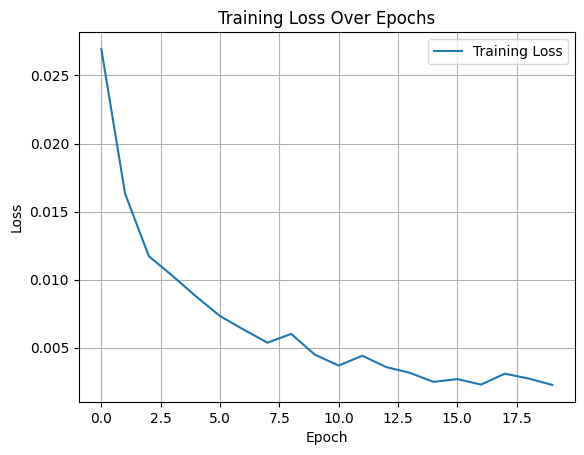

In [37]:
losses = train_model(model, train_loader, val_loader, epochs=20)

plt.plot(losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

NOTE: as the plot shows the loss after first epock came to zero!!
To prevent over-fitting
1. The easiest and fastest way to reduce the optimizer learning rate
2. reduce the epochs
* making a new training model
NOTE: if still overfitting we can change the CNN

In [8]:
# # The optimizer will make smaller steps in updating weights.
# # This slows down training but can help prevent overfitting and overshooting the optimal point.
# # It allows the model to learn more gradually and carefully, which is often helpful when:
# # Your dataset is small or simple
# # The model is large*/
# # The loss drops too fast (as in your case)
# model_1 = CatDogCNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_1.parameters(), lr = 0.0001)
# # For a more complex model, it is better to set up hyperparameters varaible

In [9]:
# # changing ebochs from 10 to 3
# import matplotlib.pyplot as plt

# def train_model_1(model_1, train_loader, val_loader, epochs=3):
#     train_losses = []

#     for epoch in range(epochs):
#         model_1.train()
#         running_loss = 0.0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         avg_loss = running_loss / len(train_loader)
#         train_losses.append(avg_loss)
#         print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

#     return train_losses

Epoch 1, Loss: 0.0023
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000


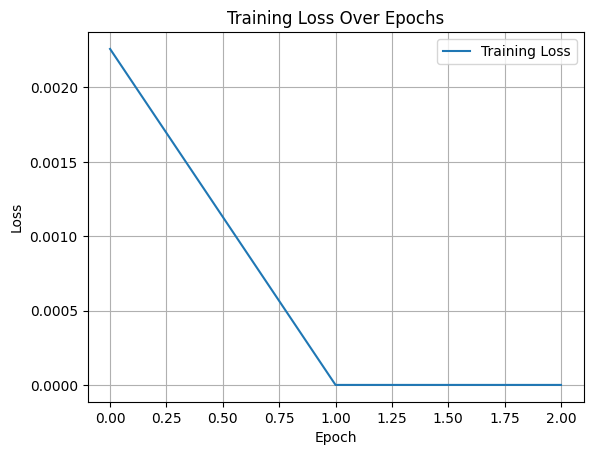

In [10]:
# losses = train_model(model_1, train_loader, val_loader, epochs=3)

# plt.plot(losses, label='Training Loss')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training Loss Over Epochs")
# plt.legend()
# plt.grid(True)
# plt.show()

## NOTE: Diagnosis
1. Dataset size is very small, so the model memorizes it instantly
2. Model might still be too powerful for such a small data
3. Possibly data leaking --> train and validation contain the same images
4. Or the dataset only contains one class(rare)

In [30]:
print(f"Train samples: {len(train_data.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(dataset.classes)

Train samples: 25000
Validation samples: 5000
['cat', 'dog']


### Problem Identified
dataset.classes is train
* If dataset. classes returns ['train'], it means ImageFolder didn’t go inside the train/ subfolders — it’s treating train/ itself as a single class folder.
* to fix it we have to change the datasts.ImageFolder

Evaluation

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, val_loader):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      outputs = model(images)
      preds = torch.argmax(outputs, axis=1).cpu().numpy()
      all_preds.extend(preds)
      all_labels.extend(labels.numpy())
  print(confusion_matrix(all_labels, all_preds))
  print(classification_report(all_labels, all_preds, target_names=['cat', 'dog']))

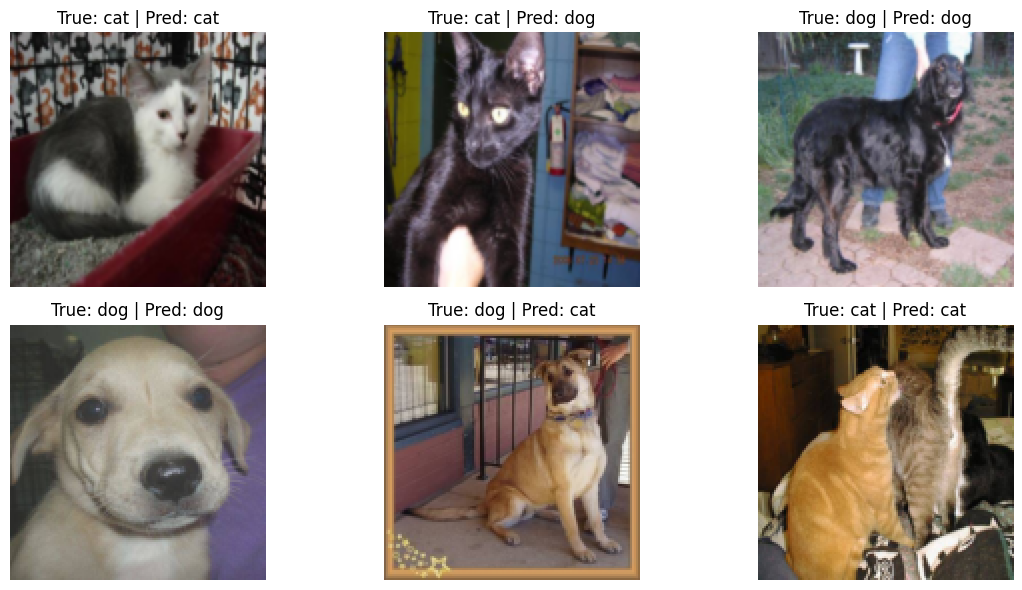

In [40]:
import matplotlib.pyplot as plt

def show_predictions(model, loader, class_names, num_images=6):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown == num_images:
                    break
                img = images[i].cpu().permute(1, 2, 0).numpy()
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]

                plt.subplot(2, 3, images_shown + 1)
                plt.imshow(img)
                plt.title(f"True: {true_label} | Pred: {pred_label}")
                plt.axis('off')
                images_shown += 1
            if images_shown == num_images:
                break
    plt.tight_layout()
    plt.show()

# Usage
class_names = dataset.classes  # ['cat', 'dog']
show_predictions(model, val_loader, class_names)


We have to increase the epochs and reduce learning rate 0.0001 to make better accuracy

Saving and make folder before saving

In [43]:
os.makedirs("pytorch_model/results", exist_ok=True)

In [44]:
plt.savefig("pytorch_model/results/sample_predictions.png")

<Figure size 640x480 with 0 Axes>

In [46]:
os.makedirs("pytorch_model/results", exist_ok=True)